In [1]:
from model import TMapper, PhiMapper, OmegaMapper, UnbalancedLoss
import torch
from collections import Counter
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from model import Hellinger, Jensen_Shannon, KL_dual, Pearson_xi

In [3]:
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [4]:
def cost_matrix(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return torch.norm(x[:, None] - y, dim=2, p=2)

def mass_variation(s):
    return (s - 1)**2

In [5]:
cuda=True

In [6]:
if cuda:
    T = TMapper(784, 784, hidden_dims=128).float().cuda()
    Xi = PhiMapper(784, 1, hidden_dims=128).float().cuda()
    f = OmegaMapper(784, 1, hidden_dims=128).float().cuda()
else:
    T = TMapper(784, 784, hidden_dims=128).float()
    Xi = PhiMapper(784, 1, hidden_dims=128).float()
    f = OmegaMapper(784, 1, hidden_dims=128).float()

loss = UnbalancedLoss(1./30000, 1./30000, cost_matrix, mass_variation, Pearson_xi)
w_optim = torch.optim.Adam(f.parameters())
t_optim = torch.optim.Adam(T.parameters())
xi_optim = torch.optim.Adam(Xi.parameters())

In [7]:
sampler1 = torch.utils.data.SubsetRandomSampler(torch.arange(30000))
sampler2 = torch.utils.data.SubsetRandomSampler(torch.arange(30000, 60000))

In [8]:
def target_transform(x):
    return x.type(torch.double).view(1)

In [9]:
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [10]:
transform1 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ReshapeTransform((-1, ))
])

transform2 = torchvision.transforms.Compose([
    #torchvision.transforms.RandomAffine((-45, 45)),
    torchvision.transforms.ToTensor(),
    ReshapeTransform((-1, ))
])


dataset1 = MNIST(root='.', download=True, train=True, transform=transform1, target_transform=target_transform)
dataset2 = MNIST(root='.', download=True, train=True, transform=transform2, target_transform=target_transform)

dl_1 = DataLoader(dataset1, batch_size=800, sampler=sampler1)
dl_2 = DataLoader(dataset2, batch_size=800, sampler=sampler2)

In [11]:
c1 = Counter(dataset1.train_labels[:30000].tolist())
c1.most_common(len(c1))

[(1, 3423),
 (7, 3107),
 (3, 3073),
 (9, 3003),
 (6, 2975),
 (0, 2961),
 (2, 2948),
 (4, 2926),
 (8, 2875),
 (5, 2709)]

In [12]:
c2 = Counter(dataset2.train_labels[30000:].tolist())
c2.most_common(len(c2))

[(1, 3319),
 (7, 3158),
 (3, 3058),
 (2, 3010),
 (8, 2976),
 (0, 2962),
 (9, 2946),
 (6, 2943),
 (4, 2916),
 (5, 2712)]

In [13]:
def train_loop(data_loader_1: torch.utils.data.DataLoader, data_loader_2: torch.utils.data.DataLoader, cuda=cuda):
    loss_value_1 = []
    loss_value_2 = []
    for i in tqdm_notebook(range(100)):
        for (X, Z_1), (Y, Z) in zip(data_loader_1, data_loader_2):

            if cuda:
                X = X.float().cuda()
                Y = Y.float().cuda()
                Z = Z.float().cuda()
                
            else:
                X = X.float()
                Y = Y.float()
                Z = Z.float()
                
            w_optim.zero_grad()
            t_optim.zero_grad()
            xi_optim.zero_grad()
            loss_value = -loss.compute(X, Z, Y, T(X, Z), Xi(X), f(Y), f(T(X, Z)))
            loss_value_1.append(loss_value)
        #    print('-loss value {}'.format(loss_value))
            loss_value.backward()
            w_optim.step()

            t_optim.zero_grad()
            xi_optim.zero_grad()
            loss_value = loss.compute(X, Z, Y, T(X, Z), Xi(X), f(Y), f(T(X, Z)))
            loss_value_2.append(loss_value)
         #   print('loss value {}'.format(loss_value))
            loss_value.backward()
            t_optim.step()
            xi_optim.step()
    return loss_value_1, loss_value_2

In [14]:
lv1, lv2 = train_loop(dl_1, dl_2)

/home/grapefroot/datascience3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


/home/grapefroot/datascience3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


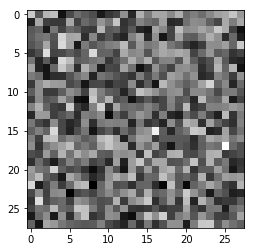

In [18]:
mapped = T(torch.cat((dataset1[0][0].view(1, -1), torch.tensor(1.).view(1, 1)), dim=1).cuda())

plt.imshow(mapped.view(28, 28).detach().cpu().numpy(), cmap=plt.cm.gray)
plt.show()

In [19]:
lv1 = np.array(lv1)
lv2 = np.array(lv2)

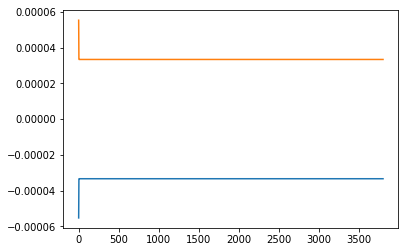

In [20]:
plt.plot(lv1)
plt.plot(lv2)